In [1]:
# see test file test_discrete_heat_forced.sh
# this file runs the second part of the test, against analytical results for discrete linear problem

In [1]:
import numpy as np
import sys
import os
from glob import glob
from json import load as json_load
from numpy.fft import fft,ifft,fftfreq,fftshift
from numpy import sin,cos,exp,log,sqrt,pi

## Matplotlib Parameters

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
colors = plt.cm.Blues(np.linspace(0,1,10))
colors = plt.cm.viridis(np.linspace(1,0,10))

In [4]:
#rcParams['lines.linewidth'] = 2
#rcParams['lines.linestyle'] = '--'
rcParams['axes.titlesize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'
#rcParams['font.family'] = "sans-serif"
#rcParams['font.family'] = ["Helvetica"]
#rcParams['font.sans-serif'] = ['Helvetica']

In [5]:
from matplotlib.ticker import FuncFormatter

def format_basis10(x):
    return np.sign(x)*10**(-np.floor(np.log10(abs(x)))+np.log10(abs(x)))

def format_exp10(x):
    return np.floor(np.log10(abs(x)))

def MyFormatter(x,lim):
    if x == 0:
        return f'$0$'
    return f'${format_basis10(x):.1f} \\times 10^{{{format_exp10(x):.0f}}}$'
    #The first argument of the format gives the first significant digits of the number with the sign preserved and brought to a range between [1-10), The next argument gives the  numbers integer exponent of 10
    #Both the first and second arguments are formatted to display only 2 decimal places due to the lack of space.
    
majorFormatter = FuncFormatter(MyFormatter)

## Import data from simulations

In [6]:
# parent directory
path = os.path.abspath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(path+'/scripts')

In [7]:
from _functions import *

In [9]:
# this is a hard coded file because the test has these fixed parameters as well
# loads parameters for first file in the ensemble, all others share the same parameters

file_suffix = 'R_92000_N_009_Ltotal_001.0_L_003_sqeps_1.000000_nu_002_T_1.0e+01_NT_003'
with open(path+'/data/params_'+file_suffix+'.json','r') as file:
    json_data = json_load(file)

In [13]:
R = int(json_data['R']/1000)
BN = json_data['BN']
Lrelative = json_data['Lrelative']
Ttotal = json_data['Ttotal']
N = json_data['N']
nu = json_data['nu']
Ltotal = json_data['Ltotal']
sqeps = json_data['sqeps']
dx = json_data['dx']
NT = json_data['NT']
NTsave = json_data['NTsave']
viscte = json_data['viscte']
sqdx = json_data['sqdx']
cfl_const = json_data['cfl_const']
nlinear = json_data['nlinear']
fkernel = json_data['fkernel']
initial_value = json_data['initial_value']
scheme = json_data['scheme']
saveformat = json_data['saveformat']

In [45]:
saveformat

'fourier'

# Plot Velocity Field Profiles

In [15]:
vfourier = np.load(path+'/data/burgers_'+file_suffix+'.npz')['u']

In [16]:
vspace = ifft(vfourier,axis=1)

In [17]:
X = fftshift( fftfreq(N) * Ltotal )

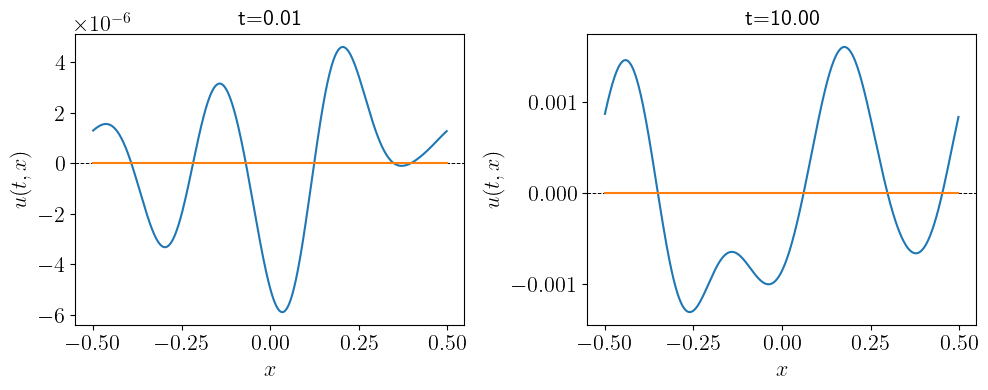

In [18]:
# initial profile of velocity field
fig, ax = plt.subplots(1,2, figsize=(10,4))

t_slice = 0
ax[0].set_title(f"t={(t_slice+1)/NTsave*Ttotal:.2f}")
ax[0].set_ylabel("$u(t,x)$")
ax[0].set_xlabel("$x$")
ax[0].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[0].plot(X,np.real(np.fft.fftshift(vspace[0,:])),label='real part')
ax[0].plot(X,np.imag(np.fft.fftshift(vspace[0,:])),label='real part')

t_slice = NTsave-1
# final profile of velocity field
ax[1].set_title(f"t={(t_slice+1)/NTsave*Ttotal:.2f}")
ax[1].set_ylabel("$u(t,x)$")
ax[1].set_xlabel("$x$")
ax[1].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[1].plot(X,np.real(np.fft.fftshift(vspace[t_slice,:])))
ax[1].plot(X,np.imag(np.fft.fftshift(vspace[t_slice,:])))

plt.tight_layout()
#plt.savefig(f'{path}/figs/bwn_velocity_profile_finite.png', dpi=200, facecolor='white', transparent=False)
plt.show()

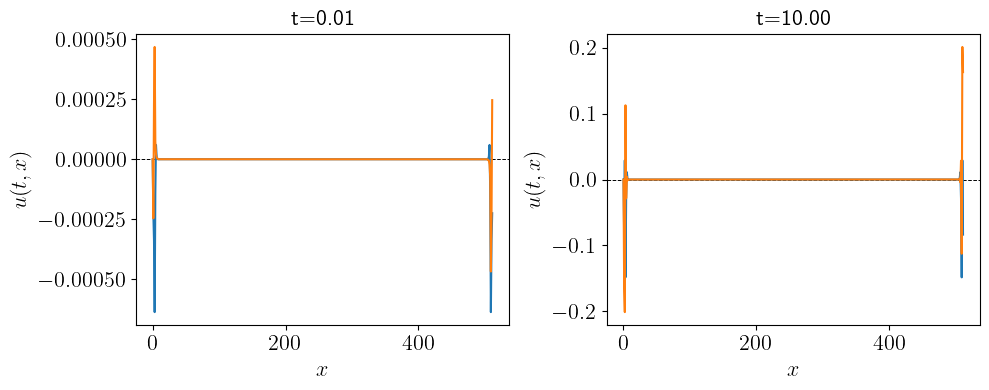

In [19]:
# fourier profile of velocity field, fourier space
fig, ax = plt.subplots(1,2, figsize=(10,4))

t_slice = 0
ax[0].set_title(f"t={(t_slice+1)/NTsave*Ttotal:.2f}")
ax[0].set_ylabel("$u(t,x)$")
ax[0].set_xlabel("$x$")
ax[0].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[0].plot(np.real(fft(vspace[t_slice,:])),label='real part')
ax[0].plot(np.imag(fft(vspace[t_slice,:])),label='imag part')

t_slice = NTsave-1
# final profile of velocity field
ax[1].set_title(f"t={(t_slice+1)/NTsave*Ttotal:.2f}")
ax[1].set_ylabel("$u(t,x)$")
ax[1].set_xlabel("$x$")
ax[1].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[1].plot(np.real(fft(vspace[t_slice,:])),label='real part')
ax[1].plot(np.imag(fft(vspace[t_slice,:])),label='imag part')

plt.tight_layout()
#plt.savefig(f'{path}/figs/bwn_velocity_profile_finite.png', dpi=200, facecolor='white', transparent=False)
plt.show()

# Setup for ensemble statistics

In [22]:
# new file suffix, takes into account that R varies now, because of the ensemble average

file_suffix = '_N_009_Ltotal_001.0_L_003_sqeps_1.000000_nu_002_T_1.0e+01_NT_003'

# this was defined in the respective .sh file
ens_size = 300

# Force statistics

check force variance
Parseval theorem states that variance in Fourier and real space is the same

$$
\sum_n \mathbb{E}|u_n|^2 = \sum_k \mathbb{E}|\widehat{u}_k|^2 = \sum_k \hat{C}_f(k)
$$

In [25]:
f_var_fourier = 0.
f_var_space   = 0.

for i in range(ens_size):
    
    R = 92000+i
    
    file_name = path+'/data/burgers_R_'+str(R)+file_suffix+'.npz'
    
    ffourier = np.load(file_name)['f']
    
    fspace   = ifft(ffourier,axis=1)
    
    #f_avg += np.mean( ffourier )
    f_var_fourier += np.mean( np.abs(ffourier)**2 )
    f_var_space   += np.mean( np.abs(fspace)**2 )
    
f_var_space   *= 1./ens_size
f_var_fourier *= 1./ens_size

In [29]:
print(f_var_space  )
print(f_var_fourier)
print(dx)

3.8113514315661053e-06
0.0019514119329618457
0.001953125


In [31]:
f_all = np.array([])

for i in range(ens_size):
    
    R = 92000+i
    
    file_name = path+'/data/burgers_R_'+str(R)+file_suffix+'.npz'
    
    fspace = ifft( np.load(file_name)['f'] , axis=1).flatten()
    
    f_all = np.concatenate(( f_all, fspace ))

In [32]:
hist, bin_edges = np.histogram( np.real(f_all), bins=300, density=True )

bin_centers = .5*bin_edges[1:] + .5*bin_edges[:-1]

In [33]:
def f_pdf(f,sigma2):
    
    cte = 1./sqrt(2.*pi*sigma2)
    
    return cte*exp(-.5*f**2/sigma2)

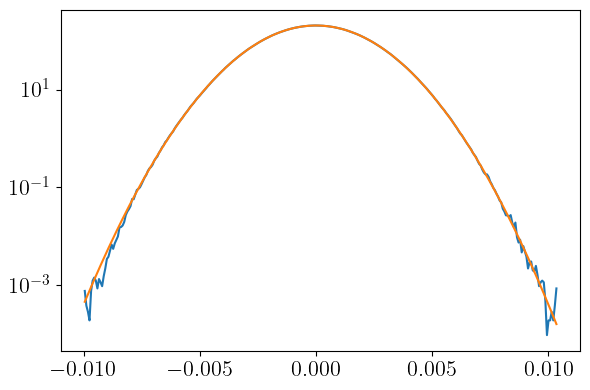

In [34]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(bin_centers, hist)

ax.plot(bin_centers, f_pdf(bin_centers,f_var_space))

ax.set_yscale('log')

plt.tight_layout()
plt.show()

## Velocity Fourier Variance in Time

In [38]:
v_var_time = np.empty(NTsave)

for i in range(ens_size):
    
    R = 92000+i
    
    file_name   = path+'/data/burgers_R_'+str(R)+file_suffix+'.npz'
    
    vfourier    = np.load(file_name)['u']
    
    vspace      = ifft(vfourier,axis=1)
    
    v_var_time += np.mean( np.abs(vfourier)**2, axis=1 )
    
v_var_time *= 1./ens_size

In [39]:
t_axis = np.arange(1,NTsave+1)/NTsave*Ttotal

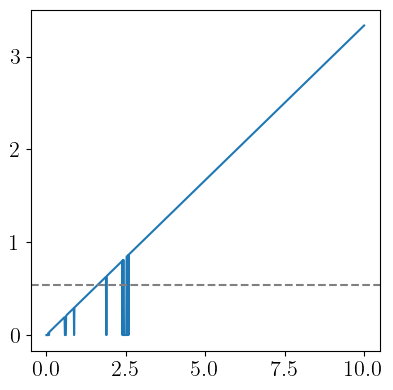

In [41]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(t_axis, v_var_time)
#ax.plot(t_axis, v_var_time_analytical, color='k')
ax.axhline(y=0.536462, color='gray', linestyle='dashed' )

plt.tight_layout()
plt.show()

In [42]:
v_all = np.array([])

for i in range(ens_size):
    
    R = 91000+i
    
    file_name = path+'/data/burgers_R_'+str(R)+file_suffix+'.npz'
    
    vspace = ifft( np.load(file_name)['u'] , axis=1)[NTsave//2:,:].flatten()
    
    v_all = np.concatenate(( v_all, vspace ))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/bt308146/Work/skewcharfun/data/burgers_R_91000_N_009_Ltotal_001.0_L_003_sqeps_1.000000_nu_002_T_1.0e+01_NT_003.npz'

In [43]:
hist, bin_edges = np.histogram( np.real(v_all), bins=300, density=True )

bin_centers = .5*bin_edges[1:] + .5*bin_edges[:-1]

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


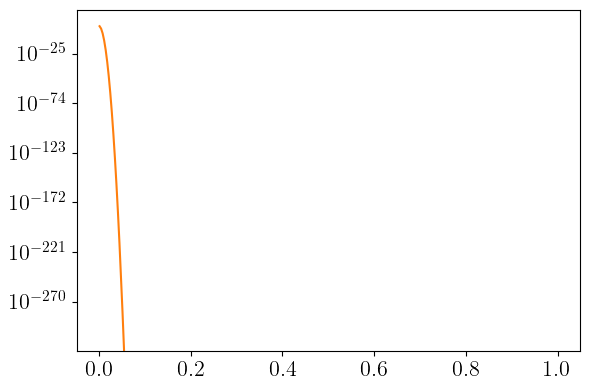

In [44]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(bin_centers, hist)

ax.plot(bin_centers, f_pdf(bin_centers,0.536462*dx*dx))

ax.set_yscale('log')

plt.tight_layout()
plt.show()

## Velocity Gradient Fourier Variance in Time

In [46]:
vg_var_time = np.empty(NTsave)

for i in range(ens_size):
    
    R = 91000+i
    
    file_name    = path+'/data/burgers_R_'+str(R)+file_suffix+'.npz'
    
    vgfourier    = np.load(file_name)['dudx']
    
    vgspace      = ifft(vgfourier, axis=1)
    
    vg_var_time += np.mean( np.abs(vgfourier)**2, axis=1 )
    
vg_var_time *= 1./ens_size

In [47]:
# data copied from mathematica, HeatAnalytical.nb
vg_var_time_analytical = [1.86034, 3.60812, 5.25264, 6.80224, 8.26443, 9.64595, 10.9529, \
12.1908, 13.3646, 14.479, 15.5379, 16.5453, 17.5046, 18.4188, 19.291, \
20.1237, 20.9195, 21.6806, 22.4091, 23.1068, 23.7756, 24.4172, \
25.033, 25.6245, 26.193, 26.7398, 27.2659, 27.7725, 28.2606, 28.731, \
29.1848, 29.6226, 30.0453, 30.4536, 30.8481, 31.2296, 31.5985, \
31.9556, 32.3012, 32.636, 32.9603, 33.2747, 33.5795, 33.8752, \
34.1621, 34.4406, 34.7111, 34.9738, 35.2291, 35.4773, 35.7186, \
35.9533, 36.1816, 36.4039, 36.6203, 36.831, 37.0362, 37.2363, \
37.4312, 37.6213, 37.8066, 37.9874, 38.1638, 38.3359, 38.504, \
38.6681, 38.8283, 38.9849, 39.1379, 39.2874, 39.4335, 39.5764, \
39.7162, 39.8529, 39.9866, 40.1176, 40.2457, 40.3711, 40.494, \
40.6143, 40.7321, 40.8476, 40.9608, 41.0717, 41.1804, 41.287, \
41.3916, 41.4942, 41.5948, 41.6935, 41.7904, 41.8856, 41.9789, \
42.0706, 42.1607, 42.2491, 42.336, 42.4214, 42.5053, 42.5877, \
42.6688, 42.7485, 42.8268, 42.9039, 42.9797, 43.0543, 43.1276, \
43.1998, 43.2709, 43.3408, 43.4096, 43.4774, 43.5442, 43.6099, \
43.6746, 43.7384, 43.8012, 43.8631, 43.9241, 43.9842, 44.0435, \
44.1019, 44.1595, 44.2163, 44.2723, 44.3275, 44.382, 44.4357, \
44.4887, 44.541, 44.5927, 44.6436, 44.6939, 44.7435, 44.7925, \
44.8408, 44.8886, 44.9357, 44.9823, 45.0282, 45.0737, 45.1185, \
45.1628, 45.2066, 45.2499, 45.2926, 45.3349, 45.3766, 45.4179, \
45.4586, 45.499, 45.5388, 45.5782, 45.6172, 45.6557, 45.6938, \
45.7314, 45.7687, 45.8055, 45.842, 45.878, 45.9137, 45.949, 45.9839, \
46.0184, 46.0526, 46.0864, 46.1199, 46.153, 46.1857, 46.2182, \
46.2503, 46.2821, 46.3135, 46.3447, 46.3755, 46.406, 46.4362, \
46.4662, 46.4958, 46.5251, 46.5542, 46.5829, 46.6114, 46.6397, \
46.6676, 46.6953, 46.7227, 46.7498, 46.7767, 46.8034, 46.8298, \
46.8559, 46.8818, 46.9075, 46.9329, 46.9581, 46.9831, 47.0078, \
47.0323, 47.0566, 47.0807, 47.1045, 47.1282, 47.1516, 47.1748, \
47.1978, 47.2206, 47.2432, 47.2656, 47.2878, 47.3098, 47.3316, \
47.3532, 47.3746, 47.3958, 47.4169, 47.4378, 47.4584, 47.4789, \
47.4993, 47.5194, 47.5394, 47.5592, 47.5789, 47.5983, 47.6176, \
47.6368, 47.6557, 47.6746, 47.6932, 47.7117, 47.7301, 47.7482, \
47.7663, 47.7841, 47.8019, 47.8195, 47.8369, 47.8542, 47.8713, \
47.8883, 47.9052, 47.9219, 47.9385, 47.9549, 47.9712, 47.9874, \
48.0034, 48.0193, 48.0351, 48.0507, 48.0663, 48.0816, 48.0969, \
48.112, 48.127, 48.1419, 48.1567, 48.1713, 48.1859, 48.2003, 48.2146, \
48.2287, 48.2428, 48.2567, 48.2706, 48.2843, 48.2979, 48.3114, \
48.3247, 48.338, 48.3512, 48.3643, 48.3772, 48.3901, 48.4028, \
48.4155, 48.428, 48.4404, 48.4528, 48.465, 48.4772, 48.4892, 48.5012, \
48.513, 48.5248, 48.5364, 48.548, 48.5595, 48.5709, 48.5821, 48.5933, \
48.6045, 48.6155, 48.6264, 48.6373, 48.648, 48.6587, 48.6693, \
48.6798, 48.6902, 48.7006, 48.7108, 48.721, 48.7311, 48.7411, 48.751, \
48.7609, 48.7707, 48.7804, 48.79, 48.7995, 48.809, 48.8184, 48.8277, \
48.8369, 48.8461, 48.8552, 48.8642, 48.8732, 48.8821, 48.8909, \
48.8996, 48.9083, 48.9169, 48.9254, 48.9339, 48.9423, 48.9506, \
48.9589, 48.9671, 48.9753, 48.9833, 48.9913, 48.9993, 49.0072, \
49.015, 49.0227, 49.0304, 49.0381, 49.0457, 49.0532, 49.0606, 49.068, \
49.0754, 49.0826, 49.0899, 49.097, 49.1041, 49.1112, 49.1182, \
49.1251, 49.132, 49.1389, 49.1456, 49.1524, 49.159, 49.1657, 49.1722, \
49.1787, 49.1852, 49.1916, 49.198, 49.2043, 49.2106, 49.2168, \
49.2229, 49.2291, 49.2351, 49.2411, 49.2471, 49.253, 49.2589, \
49.2648, 49.2705, 49.2763, 49.282, 49.2876, 49.2932, 49.2988, \
49.3043, 49.3098, 49.3152, 49.3206, 49.326, 49.3313, 49.3365, \
49.3417, 49.3469, 49.3521, 49.3572, 49.3622, 49.3672, 49.3722, \
49.3771, 49.382, 49.3869, 49.3917, 49.3965, 49.4013, 49.406, 49.4106, \
49.4153, 49.4199, 49.4244, 49.429, 49.4335, 49.4379, 49.4423, \
49.4467, 49.4511, 49.4554, 49.4597, 49.4639, 49.4682, 49.4723, \
49.4765, 49.4806, 49.4847, 49.4887, 49.4928, 49.4968, 49.5007, \
49.5046, 49.5085, 49.5124, 49.5162, 49.5201, 49.5238, 49.5276, \
49.5313, 49.535, 49.5386, 49.5423, 49.5459, 49.5494, 49.553, 49.5565, \
49.56, 49.5634, 49.5669, 49.5703, 49.5737, 49.577, 49.5803, 49.5836, \
49.5869, 49.5902, 49.5934, 49.5966, 49.5998, 49.6029, 49.606, \
49.6091, 49.6122, 49.6153, 49.6183, 49.6213, 49.6243, 49.6272, \
49.6302, 49.6331, 49.6359, 49.6388, 49.6417, 49.6445, 49.6473, 49.65, \
49.6528, 49.6555, 49.6582, 49.6609, 49.6636, 49.6662, 49.6689, \
49.6715, 49.674, 49.6766, 49.6792, 49.6817, 49.6842, 49.6867, \
49.6891, 49.6916, 49.694, 49.6964, 49.6988, 49.7012, 49.7035, \
49.7058, 49.7082, 49.7105, 49.7127, 49.715, 49.7172, 49.7195, \
49.7217, 49.7239, 49.726, 49.7282, 49.7303, 49.7324, 49.7345, \
49.7366, 49.7387, 49.7408, 49.7428, 49.7448, 49.7468, 49.7488, \
49.7508, 49.7528, 49.7547, 49.7566, 49.7585, 49.7604, 49.7623, \
49.7642, 49.766, 49.7679, 49.7697, 49.7715, 49.7733, 49.7751, \
49.7769, 49.7786, 49.7804, 49.7821, 49.7838, 49.7855, 49.7872, \
49.7889, 49.7905, 49.7922, 49.7938, 49.7954, 49.797, 49.7986, \
49.8002, 49.8018, 49.8034, 49.8049, 49.8064, 49.808, 49.8095, 49.811, \
49.8125, 49.8139, 49.8154, 49.8168, 49.8183, 49.8197, 49.8211, \
49.8225, 49.8239, 49.8253, 49.8267, 49.8281, 49.8294, 49.8307, \
49.8321, 49.8334, 49.8347, 49.836, 49.8373, 49.8386, 49.8398, \
49.8411, 49.8424, 49.8436, 49.8448, 49.846, 49.8473, 49.8485, \
49.8497, 49.8508, 49.852, 49.8532, 49.8543, 49.8555, 49.8566, \
49.8577, 49.8589, 49.86, 49.8611, 49.8622, 49.8632, 49.8643, 49.8654, \
49.8664, 49.8675, 49.8685, 49.8696, 49.8706, 49.8716, 49.8726, \
49.8736, 49.8746, 49.8756, 49.8766, 49.8776, 49.8785, 49.8795, \
49.8804, 49.8814, 49.8823, 49.8832, 49.8841, 49.885, 49.886, 49.8869, \
49.8877, 49.8886, 49.8895, 49.8904, 49.8912, 49.8921, 49.8929, \
49.8938, 49.8946, 49.8954, 49.8963, 49.8971, 49.8979, 49.8987, \
49.8995, 49.9003, 49.9011, 49.9018, 49.9026, 49.9034, 49.9041, \
49.9049, 49.9056, 49.9064, 49.9071, 49.9078, 49.9086, 49.9093, 49.91, \
49.9107, 49.9114, 49.9121, 49.9128, 49.9135, 49.9142, 49.9148, \
49.9155, 49.9162, 49.9168, 49.9175, 49.9181, 49.9188, 49.9194, \
49.9201, 49.9207, 49.9213, 49.9219, 49.9225, 49.9232, 49.9238, \
49.9244, 49.925, 49.9255, 49.9261, 49.9267, 49.9273, 49.9279, \
49.9284, 49.929, 49.9295, 49.9301, 49.9306, 49.9312, 49.9317, \
49.9323, 49.9328, 49.9333, 49.9339, 49.9344, 49.9349, 49.9354, \
49.9359, 49.9364, 49.9369, 49.9374, 49.9379, 49.9384, 49.9389, \
49.9394, 49.9398, 49.9403, 49.9408, 49.9412, 49.9417, 49.9422, \
49.9426, 49.9431, 49.9435, 49.944, 49.9444, 49.9448, 49.9453, \
49.9457, 49.9461, 49.9466, 49.947, 49.9474, 49.9478, 49.9482, \
49.9486, 49.949, 49.9494, 49.9498, 49.9502, 49.9506, 49.951, 49.9514, \
49.9518, 49.9521, 49.9525, 49.9529, 49.9533, 49.9536, 49.954, \
49.9544, 49.9547, 49.9551, 49.9554, 49.9558, 49.9561, 49.9565, \
49.9568, 49.9572, 49.9575, 49.9578, 49.9582, 49.9585, 49.9588, \
49.9591, 49.9595, 49.9598, 49.9601, 49.9604, 49.9607, 49.961, \
49.9613, 49.9616, 49.9619, 49.9622, 49.9625, 49.9628, 49.9631, \
49.9634, 49.9637, 49.964, 49.9643, 49.9646, 49.9648, 49.9651, \
49.9654, 49.9657, 49.9659, 49.9662, 49.9665, 49.9667, 49.967, \
49.9672, 49.9675, 49.9678, 49.968, 49.9683, 49.9685, 49.9688, 49.969, \
49.9692, 49.9695, 49.9697, 49.97, 49.9702, 49.9704, 49.9707, 49.9709, \
49.9711, 49.9714, 49.9716, 49.9718, 49.972, 49.9722, 49.9725, \
49.9727, 49.9729, 49.9731, 49.9733, 49.9735, 49.9737, 49.9739, \
49.9742, 49.9744, 49.9746, 49.9748, 49.975, 49.9752, 49.9753, \
49.9755, 49.9757, 49.9759, 49.9761, 49.9763, 49.9765, 49.9767, \
49.9769, 49.977, 49.9772, 49.9774, 49.9776, 49.9778, 49.9779, \
49.9781, 49.9783, 49.9784, 49.9786, 49.9788, 49.9789, 49.9791, \
49.9793, 49.9794, 49.9796, 49.9798, 49.9799, 49.9801, 49.9802, \
49.9804, 49.9805, 49.9807, 49.9809, 49.981, 49.9812, 49.9813, \
49.9814, 49.9816, 49.9817, 49.9819, 49.982, 49.9822, 49.9823, \
49.9824, 49.9826, 49.9827, 49.9829, 49.983, 49.9831, 49.9833, \
49.9834, 49.9835, 49.9836, 49.9838, 49.9839, 49.984, 49.9842, \
49.9843, 49.9844, 49.9845, 49.9847, 49.9848, 49.9849, 49.985, \
49.9851, 49.9852, 49.9854, 49.9855, 49.9856, 49.9857, 49.9858, \
49.9859, 49.986, 49.9861, 49.9863, 49.9864, 49.9865, 49.9866, \
49.9867, 49.9868, 49.9869, 49.987, 49.9871, 49.9872, 49.9873, \
49.9874, 49.9875, 49.9876, 49.9877, 49.9878, 49.9879, 49.988, \
49.9881, 49.9882, 49.9883, 49.9884, 49.9884, 49.9885, 49.9886, \
49.9887, 49.9888, 49.9889, 49.989, 49.9891, 49.9892, 49.9892, \
49.9893, 49.9894, 49.9895, 49.9896, 49.9897, 49.9897, 49.9898, \
49.9899, 49.99, 49.9901, 49.9901, 49.9902, 49.9903, 49.9904, 49.9904, \
49.9905, 49.9906, 49.9907, 49.9907, 49.9908, 49.9909, 49.991, 49.991, \
49.9911, 49.9912, 49.9912, 49.9913, 49.9914, 49.9914, 49.9915, \
49.9916, 49.9916, 49.9917, 49.9918, 49.9918, 49.9919, 49.992, 49.992, \
49.9921, 49.9922, 49.9922, 49.9923, 49.9923, 49.9924, 49.9925, \
49.9925, 49.9926, 49.9926, 49.9927, 49.9927, 49.9928, 49.9929, \
49.9929, 49.993, 49.993, 49.9931, 49.9931, 49.9932, 49.9932, 49.9933, \
49.9934, 49.9934, 49.9935, 49.9935, 49.9936, 49.9936, 49.9937, \
49.9937, 49.9938, 49.9938, 49.9939, 49.9939, 49.994, 49.994, 49.994, \
49.9941, 49.9941, 49.9942, 49.9942, 49.9943, 49.9943, 49.9944, \
49.9944, 49.9945, 49.9945, 49.9945, 49.9946, 49.9946, 49.9947, \
49.9947]

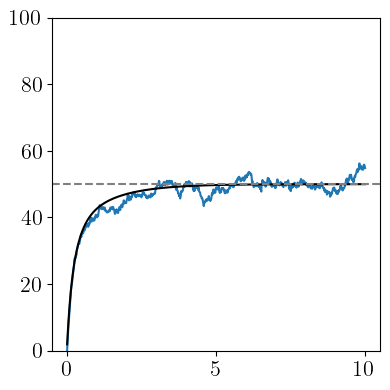

In [49]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(t_axis, vg_var_time*N)
ax.plot(t_axis, vg_var_time_analytical, color='k')
ax.axhline(y=50., color='gray', linestyle='dashed' )
ax.set_ylim(0.,100.)

plt.tight_layout()
plt.show()

In [50]:
vg_all = np.array([])

for i in range(ens_size):
    
    R = 91000+i
    
    file_name = path+'/data/burgers_R_'+str(R)+file_suffix+'.npz'
    
    vgspace = ifft( np.load(file_name)['dudx'] , axis=1)[NTsave//2:,:].flatten()
    
    vg_all = np.concatenate(( vg_all, vgspace ))

In [51]:
hist, bin_edges = np.histogram( np.real(vg_all), bins=300, density=True )

bin_centers = .5*bin_edges[1:] + .5*bin_edges[:-1]

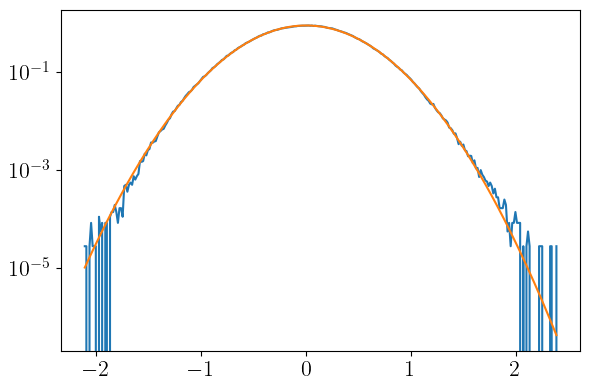

In [53]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(bin_centers, hist)

ax.plot(bin_centers, f_pdf(bin_centers,50.*dx*dx))

ax.set_yscale('log')

plt.tight_layout()
plt.show()